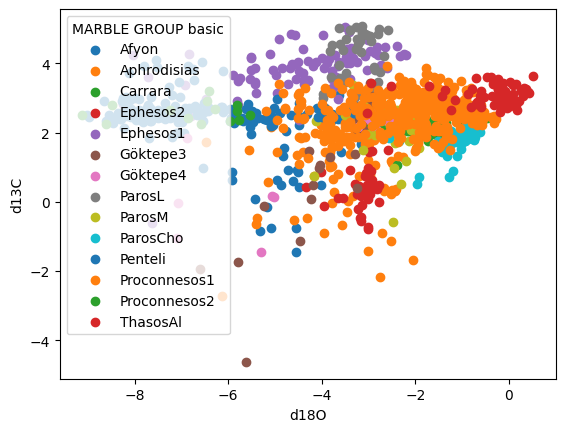

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# load in the data 
df = pd.read_excel('1_DB_Basic_dec_24.xlsx')

classes = df["MARBLE GROUP basic"].unique()

for class_name in classes:
    class_mask = df['MARBLE GROUP basic'] == class_name
    plt.scatter(df.loc[class_mask, "d18O"], df.loc[class_mask, "d13C"], label=class_name)

plt.xlabel('d18O')
plt.ylabel('d13C')
plt.legend(title='MARBLE GROUP basic')
plt.show()


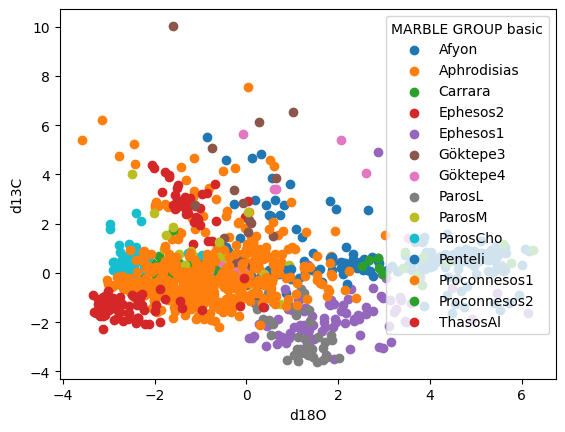

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
transformed_isotopes = clf.fit_transform(df[["d18O", "d13C"]], df["MARBLE GROUP basic"])

classes = df["MARBLE GROUP basic"].unique()

for class_name in classes:
    class_mask = df["MARBLE GROUP basic"] == class_name
    plt.scatter(transformed_isotopes[class_mask, 0], transformed_isotopes[class_mask, 1], label=class_name)
plt.xlabel('d18O')
plt.ylabel('d13C')
plt.legend(title='MARBLE GROUP basic')
plt.show()